In [113]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl
import datetime as dt
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa
import statsmodels.formula.api as smf
import fredapi
import re

In [114]:
sys.path.append('../../../library/metrics/metrics/')
import metrics
import importlib
importlib.reload(metrics)

<module 'metrics' from '../../../library/metrics/metrics/metrics.py'>

In [115]:
%matplotlib inline

In [116]:
lbdata = pd.read_csv('./data/in/lbdata.csv',index_col=0)
lbdata.index.name = None
# lbdata

In [117]:
tcode_file = pd.read_csv('./data/in/var_tcode_desc_slow.csv')
tcode_file = tcode_file[['FRED','TCODE_MY_BBE','TCODE_MY_FMD']]
tcode_file['FRED'] = tcode_file['FRED'].apply(lambda x: re.sub('[ :&]','_',str(x)))
tcodeslb = np.array([tcode_file.loc[tcode_file['FRED'].str.lower()==fred_code.lower(),'TCODE_MY_BBE'].values[0] for fred_code in lbdata.columns])
tcodesmy = np.array([tcode_file.loc[tcode_file['FRED'].str.lower()==fred_code.lower(),'TCODE_MY_FMD'].values[0] for fred_code in lbdata.columns])
# ISO-8859-1
# tcode_file.to_csv('./data/in/var_tcode_desc_slow.csv',encoding="utf-8",index=None)
# tcodeslb

In [118]:
df_vars = lbdata.loc[:,['INDPRO','CPIAUCSL','FEDFUNDS']]
# df

In [119]:
SFM_lb = metrics.sfm(lbdata,tcodeslb,nF=3)
df_fac_lb = SFM_lb.Factors

In [120]:
SFM_my = metrics.sfm(lbdata,tcodesmy,nF=3)
df_fac_my = SFM_my.Factors

In [121]:
df_lb = df_vars.join(df_fac_lb,how='outer')
df_my = df_vars.join(df_fac_my,how='outer')
# df

In [122]:
df_lb['d_IP']  = 100*df_lb['INDPRO'].apply(lambda x: np.log(x)).diff()
df_lb['d_CPI'] = 100*df_lb['CPIAUCSL'].apply(lambda x: np.log(x)).diff()
df_lb['d_FFR'] = 1  *df_lb['FEDFUNDS'].diff()

In [123]:
df_my['d_IP']  = 100*df_my['INDPRO'].apply(lambda x: np.log(x)).diff()
df_my['d_CPI'] = 100*df_my['CPIAUCSL'].apply(lambda x: np.log(x)).diff()
df_my['d_FFR'] = 1  *df_my['FEDFUNDS'].diff()

In [124]:
var_names = ['Industrical production','Price level','Fed Funds Rate']
nL = 13
nH = 48

In [125]:
b_lb,_,_,_,_ = metrics.ols(df_lb.loc[:,['d_IP','d_CPI','FEDFUNDS']].values,
                       df_lb.loc[:,['Factor_1','Factor_2','Factor_3','FEDFUNDS']].values)
b_lb = b_lb[1:,:]

The data passed does not contain a constant. Automatically adding a constant


In [126]:
b_my,_,_,_,_ = metrics.ols(df_my.loc[:,['d_IP','d_CPI','FEDFUNDS']].values,
                       df_my.loc[:,['Factor_1','Factor_2','Factor_3','FEDFUNDS']].values)
b_my = b_my[1:,:]

The data passed does not contain a constant. Automatically adding a constant


In [127]:
Mdlbbevar_lb = metrics.varm(df_lb,
               nL=nL,
               var_names=['d_IP','d_CPI','FEDFUNDS'])
Mdlbbevar_lb.irf(nH,method='ch')

In [128]:
Mdlbbefavar_lb = metrics.varm(df_lb,
               nL=nL,
               var_names=['Factor_1','Factor_2','Factor_3','FEDFUNDS'])
Mdlbbefavar_lb.irf(nH,method='ch')

In [129]:
Mdlbbevar_my = metrics.varm(df_my,
               nL=nL,
               var_names=['d_IP','d_CPI','FEDFUNDS'])
Mdlbbevar_my.irf(nH,method='ch')

In [130]:
Mdlbbefavar_my = metrics.varm(df_my,
               nL=nL,
               var_names=['Factor_1','Factor_2','Factor_3','FEDFUNDS'])
Mdlbbefavar_my.irf(nH,method='ch')

#### IRFs from VAR vs FAVAR

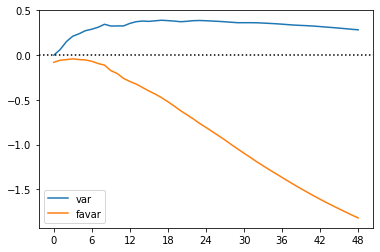

In [131]:
idr = 1
ids = 2
mpl.plot(Mdlbbevar_lb.irfs.ch.irc.mean[:,idr,ids]);
mpl.plot(np.cumsum(Mdlbbefavar_lb.irfs.ch.ir.mean[:,:,ids+1]@b_lb[:,idr]));
mpl.axhline(0,color='k',ls=':');
mpl.xticks(range(0,49,6))
mpl.legend(['var','favar'])
# mpl.title(var_names[ids] + ' --> ' + var_names[idr]);

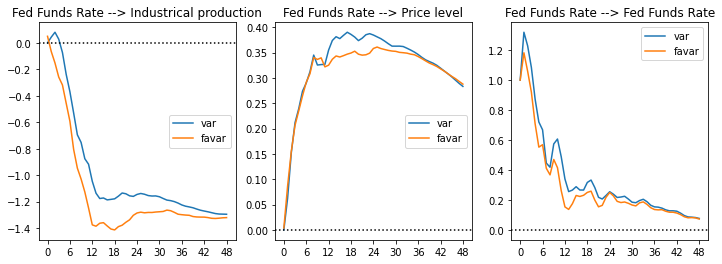

In [132]:
ids = 2
fig, axes = mpl.subplots(1,3,figsize=(12,4))
for idr in [0,1,2]:
    if idr == 2:
        axes[idr].plot(Mdlbbevar_my.irfs.ch.ir.mean[:,idr,ids]);
        axes[idr].plot(Mdlbbefavar_my.irfs.ch.ir.mean[:,:,ids+1]@b_my[:,idr]);
    else:
        axes[idr].plot(np.cumsum(Mdlbbevar_my.irfs.ch.ir.mean[:,idr,ids]));
        axes[idr].plot(np.cumsum(Mdlbbefavar_my.irfs.ch.ir.mean[:,:,ids+1]@b_my[:,idr]));
    axes[idr].axhline(0,color='k',ls=':');
    axes[idr].set_xticks(range(0,49,6))
    axes[idr].legend(['var','favar'])
    axes[idr].set_title(var_names[ids] + ' --> ' + var_names[idr]);

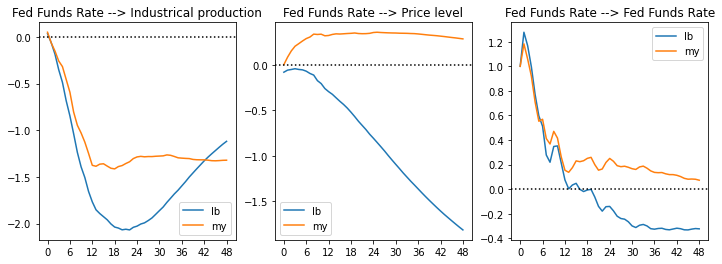

In [133]:
ids = 2
fig, axes = mpl.subplots(1,3,figsize=(12,4))
for idr in [0,1,2]:
    if idr == 2:
        axes[idr].plot(Mdlbbefavar_lb.irfs.ch.ir.mean[:,:,ids+1]@b_lb[:,idr]);
        axes[idr].plot(Mdlbbefavar_my.irfs.ch.ir.mean[:,:,ids+1]@b_my[:,idr]);
    else:
        axes[idr].plot(np.cumsum(Mdlbbefavar_lb.irfs.ch.ir.mean[:,:,ids+1]@b_lb[:,idr]));
        axes[idr].plot(np.cumsum(Mdlbbefavar_my.irfs.ch.ir.mean[:,:,ids+1]@b_my[:,idr]));
    axes[idr].axhline(0,color='k',ls=':');
    axes[idr].set_xticks(range(0,49,6))
    axes[idr].legend(['lb','my'])
    axes[idr].set_title(var_names[ids] + ' --> ' + var_names[idr]);

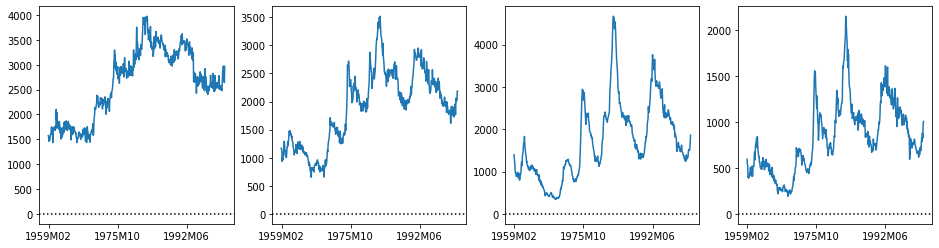

In [134]:
fig, axes = mpl.subplots(1,4,figsize=(16,4))
axes[0].plot(lbdata['UEMPLT5']);
axes[0].axhline(0,color='k',ls=':');
axes[0].set_xticks(range(1,513,200));
axes[1].plot(lbdata['UEMP5TO14']);
axes[1].axhline(0,color='k',ls=':');
axes[1].set_xticks(range(1,513,200));
axes[2].plot(lbdata['UEMP15OV']);
axes[2].axhline(0,color='k',ls=':');
axes[2].set_xticks(range(1,513,200));
axes[3].plot(lbdata['UEMP15T26']);
axes[3].axhline(0,color='k',ls=':');
axes[3].set_xticks(range(1,513,200));

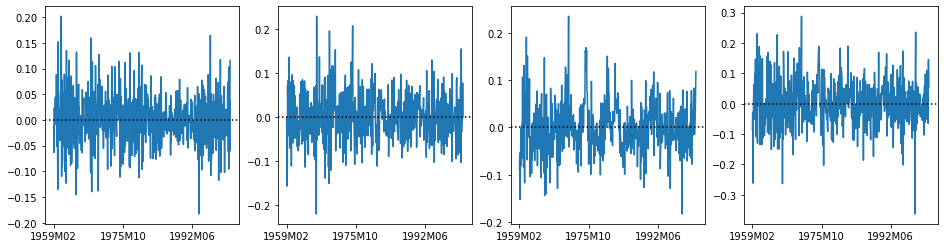

In [135]:
fig, axes = mpl.subplots(1,4,figsize=(16,4))
axes[0].plot(lbdata['UEMPLT5'].apply(lambda x: np.log(x)).diff());
axes[0].axhline(0,color='k',ls=':');
axes[0].set_xticks(range(1,513,200));
axes[1].plot(lbdata['UEMP5TO14'].apply(lambda x: np.log(x)).diff());
axes[1].axhline(0,color='k',ls=':');
axes[1].set_xticks(range(1,513,200));
axes[2].plot(lbdata['UEMP15OV'].apply(lambda x: np.log(x)).diff());
axes[2].axhline(0,color='k',ls=':');
axes[2].set_xticks(range(1,513,200));
axes[3].plot(lbdata['UEMP15T26'].apply(lambda x: np.log(x)).diff());
axes[3].axhline(0,color='k',ls=':');
axes[3].set_xticks(range(1,513,200));